# 05 - Simulación Monte Carlo (modelo moderno 2018–2024)

En este notebook uso el modelo moderno entrenado con partidos desde 2018
para simular torneos tipo Mundial mediante Monte Carlo y estimar la 
probabilidad de que cada selección sea campeona.


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import os
os.getcwd()


'C:\\Users\\lmosquen\\Desktop\\Python\\Proyecto mundial\\worldcup-2026-prediction-main\\worldcup-2026-prediction-main\\notebooks'

In [3]:
df = pd.read_csv("../data/processed/matches_modern_features.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date").reset_index(drop=True)

df.shape, df.head()


((4593, 20),
         date    home_team     away_team                   tournament  result  \
 0 2018-03-22   Kyrgyzstan       Myanmar  AFC Asian Cup qualification       1   
 1 2018-03-27  Afghanistan      Cambodia  AFC Asian Cup qualification       1   
 2 2018-03-27      Bahrain  Turkmenistan  AFC Asian Cup qualification       1   
 3 2018-03-27      Myanmar         Macau  AFC Asian Cup qualification       1   
 4 2018-03-27       Jordan       Vietnam  AFC Asian Cup qualification       0   
 
    home_win  home_power_v3  away_power_v3  power_diff_v3  home_form_5  \
 0         1       0.525964       0.256129       0.269835          2.0   
 1         1       0.276640       0.196068       0.080572          1.0   
 2         1       0.556258       0.471649       0.084609          2.4   
 3         1       0.256129       0.097129       0.158999          1.6   
 4         0       0.683043       0.460460       0.222583          1.8   
 
    away_form_5  tournament_importance  home_market_v

In [4]:
elo_official = pd.read_csv("../data/external/team_elo_official.csv")

elo_dict = dict(zip(elo_official.team, elo_official.elo))


In [5]:
teams = sorted(df['home_team'].unique())

def team_rating(team):
    return elo_dict.get(team, 1500)   



In [6]:
team_features = pd.DataFrame({'team': teams}).set_index('team')


In [7]:
elo_idx = elo_official.set_index('team')
team_features = team_features.join(elo_idx['elo'])


In [8]:
team_features.head()


,elo
team,
Afghanistan,1033.0
Albania,1664.0
Algeria,1718.0
Andorra,1083.0
Angola,1566.0


In [9]:
# equipos sin Elo en nuestro csv actual
missing_elo = team_features[team_features['elo'].isna()].index.tolist()
len(missing_elo), missing_elo[:20]


(8,
 ['China PR',
  'DR Congo',
  'Macau',
  'Republic of Ireland',
  'Saint Vincent and the Grenadines',
  'São Tomé and Príncipe',
  'Timor-Leste',
  'United States Virgin Islands'])

In [10]:
# 1) Cargo los ratings modernos que calculamos antes
ratings_modern = pd.read_csv("../data/processed/team_ratings_modern.csv")

# Aseguro nombre de columna consistente
ratings_modern = ratings_modern.rename(columns={"power_score_moderno": "modern_power"})

# 2) Uno por 'team'
team_features = team_features.join(
    ratings_modern.set_index("team")[["modern_power"]],
    how="left"
)

team_features.head()


,elo,modern_power
team,,
Afghanistan,1033.0,-0.086667
Albania,1664.0,0.254930
Algeria,1718.0,0.639744
Andorra,1083.0,-0.383803
Angola,1566.0,0.392742


In [11]:
team_features.columns.tolist()


['elo', 'modern_power']

In [12]:
import pandas as pd

market_df = pd.read_csv("../data/external/team_market_values.csv")
market_df.head()
market_df.columns


Index(['team', 'market_value_millions'], dtype='object')

In [13]:
market_df = market_df.rename(columns={
    "Team": "team",
    "Selección": "team",
    "Selection": "team",
    "Pais": "team",
    "Country": "team",
    "Value": "market_value",
    "MarketValue": "market_value",
    "market": "market_value",
    "valor_mercado": "market_value"
    
})

market_df.head()


,team,market_value_millions
0,Argentina,900
1,Brazil,1200
2,England,1100
3,France,1050
4,Portugal,950


In [14]:
import pandas as pd

market_df = pd.read_csv("../data/external/team_market_values.csv")

print(market_df.columns.tolist())
market_df.head()


['team', 'market_value_millions']


,team,market_value_millions
0,Argentina,900
1,Brazil,1200
2,England,1100
3,France,1050
4,Portugal,950


In [15]:
market_df = market_df.rename(columns={
    "team": "team",
    "market_value_millions": "market_value"
})

market_df.head()


,team,market_value
0,Argentina,900
1,Brazil,1200
2,England,1100
3,France,1050
4,Portugal,950


In [16]:
market_df.columns


Index(['team', 'market_value'], dtype='object')

In [17]:
# Aseguro que team_features tiene 'team' como columna
if "team" not in team_features.columns:
    team_features = team_features.reset_index().rename(columns={"index": "team"})

# Merge
team_features = team_features.merge(
    market_df[["team", "market_value"]],
    on="team",
    how="left"
)

# Vuelvo a dejar team como índice
team_features = team_features.set_index("team")

print(team_features.columns.tolist())
team_features.head()


['elo', 'modern_power', 'market_value']


,elo,modern_power,market_value
team,,,
Afghanistan,1033.0,-0.086667,NaN
Albania,1664.0,0.254930,NaN
Algeria,1718.0,0.639744,NaN
Andorra,1083.0,-0.383803,NaN
Angola,1566.0,0.392742,NaN


In [32]:
# Diccionario de valores de mercado estimados (en millones)
manual_market_values = {
    "United States": 280,
    "Norway": 330,
    "Austria": 180,
    "Algeria": 150,
    "Panama": 20,
    "Jordan": 8,
    "Uzbekistan": 15,
    "New Zealand": 12,
    "Cape Verde": 25,
    "Haiti": 12,
    "Curaçao": 18,
    "Scotland": 190,
}

# Completo market_value donde sea NaN (solo para equipos presentes en el diccionario)
for team, value in manual_market_values.items():
    if team in team_features.index:
        if pd.isna(team_features.loc[team, "market_value"]):
            team_features.loc[team, "market_value"] = value


In [37]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ["elo", "modern_power", "market_value"]  

scaler = MinMaxScaler()
team_features[["elo_norm", "modern_norm", "market_norm"]] = scaler.fit_transform(
    team_features[cols_to_scale]
)

# Pesos 
w_elo = 0.55
w_modern = 0.35
w_market = 0.10

team_features["final_power"] = (
    w_elo    * team_features["elo_norm"] +
    w_modern * team_features["modern_norm"] +
    w_market * team_features["market_norm"]
)

team_features.sort_values("final_power", ascending=False).head(20)


,team,elo,modern_power,market_value,elo_norm,modern_norm,market_norm,final_power
181,Spain,2171.0,0.970647,900.0,1.000000,0.956571,0.741379,0.958938
60,England,2042.0,0.917277,1100.0,0.917148,0.927363,0.913793,0.920388
69,France,2062.0,0.777083,1050.0,0.929994,0.850637,0.870690,0.896288
7,Argentina,2113.0,0.693443,900.0,0.962749,0.804862,0.741379,0.885351
27,Brazil,1978.0,0.777976,1200.0,0.876044,0.851126,1.000000,0.879718
153,Portugal,1976.0,0.832487,950.0,0.874759,0.880959,0.784483,0.867901
74,Germany,1910.0,0.983060,850.0,0.832370,0.963365,0.698276,0.864809
134,Netherlands,1959.0,0.904762,820.0,0.863841,0.920514,0.672414,0.864534
95,Italy,1859.0,0.720942,750.0,0.799615,0.819912,0.612069,0.787964
98,Japan,1878.0,0.918519,220.0,0.811818,0.928042,0.155172,0.786832


In [34]:
# 1) Top 40 según el rating híbrido final_power
top40 = (
    team_features
    .sort_values('final_power', ascending=False)
    .head(40)
)

teams_40 = list(top40.index)
top40[['final_power']].head(20)


,final_power
181,0.958938
60,0.920388
69,0.896288
7,0.885351
27,0.879718
153,0.867901
74,0.864809
134,0.864534
95,0.787964
98,0.786832


In [35]:
import numpy as np

# ---- 1) Función para simular UN partido (sin empates) ----
def simulate_match(home, away):
    """
    Devuelve el ganador entre home y away usando final_power.
    No hay empates: se asume que después de 120' + penales alguien gana.
    """
    r_home = team_features.loc[home, "final_power"]
    r_away = team_features.loc[away, "final_power"]

    # Probabilidad de que gane el local (tipo Bradley-Terry simplificado)
    p_home = r_home / (r_home + r_away)

    
    if np.random.rand() < p_home:
        return home
    else:
        return away

import random

def simulate_tournament_40(teams):
    """
    Torneo tipo Mundial con 40 selecciones:
    - Top 24 (por final_power) van directo a la 'fase principal'
    - Últimos 16 juegan un play-in → 8 ganadores
    - 24 + 8 = 32 → eliminación directa estándar hasta el campeón
    """
    # Ordeno por fuerza (rating híbrido)
    ordered = sorted(
        teams,
        key=lambda t: team_features.loc[t, "final_power"],
        reverse=True
    )

    direct_24 = ordered[:24]    # pasan directo
    playoffs_16 = ordered[24:]  # juegan ronda previa (16 equipos)

    # Play-in
    random.shuffle(playoffs_16)
    pre_winners = []
    for i in range(0, len(playoffs_16), 2):
        home = playoffs_16[i]
        away = playoffs_16[i+1]
        winner = simulate_match(home, away)
        # si llega a salir DRAW, desempate rápido
        if winner == "DRAW":
            winner = simulate_match(home, away, draw_prob=0.0)
        pre_winners.append(winner)

    # Ahora tenemos 24 + 8 = 32 equipos para la fase principal
    remaining = direct_24 + pre_winners
    random.shuffle(remaining)

    # Eliminación directa estándar
    while len(remaining) > 1:
        next_round = []
        for i in range(0, len(remaining), 2):
            home = remaining[i]
            away = remaining[i+1]
            winner = simulate_match(home, away)
            if winner == "DRAW":
                winner = simulate_match(home, away, draw_prob=0.0)
            next_round.append(winner)
        remaining = next_round

    return remaining[0]  # campeón



In [36]:
N_SIM = 5000
champions = []

for i in range(N_SIM):
    winner = simulate_tournament_40(teams_40)
    champions.append(winner)

champions_series = pd.Series(champions)
champions_prob = (champions_series.value_counts(normalize=True) * 100).round(2)

champions_prob.head(20)


181    5.52
7      4.90
69     4.60
27     4.42
60     4.42
74     4.26
134    4.20
153    3.96
18     3.28
206    3.14
47     3.10
95     3.08
92     3.02
98     3.00
143    3.00
186    2.88
168    2.84
42     2.84
204    2.80
124    2.78
Name: proportion, dtype: float64

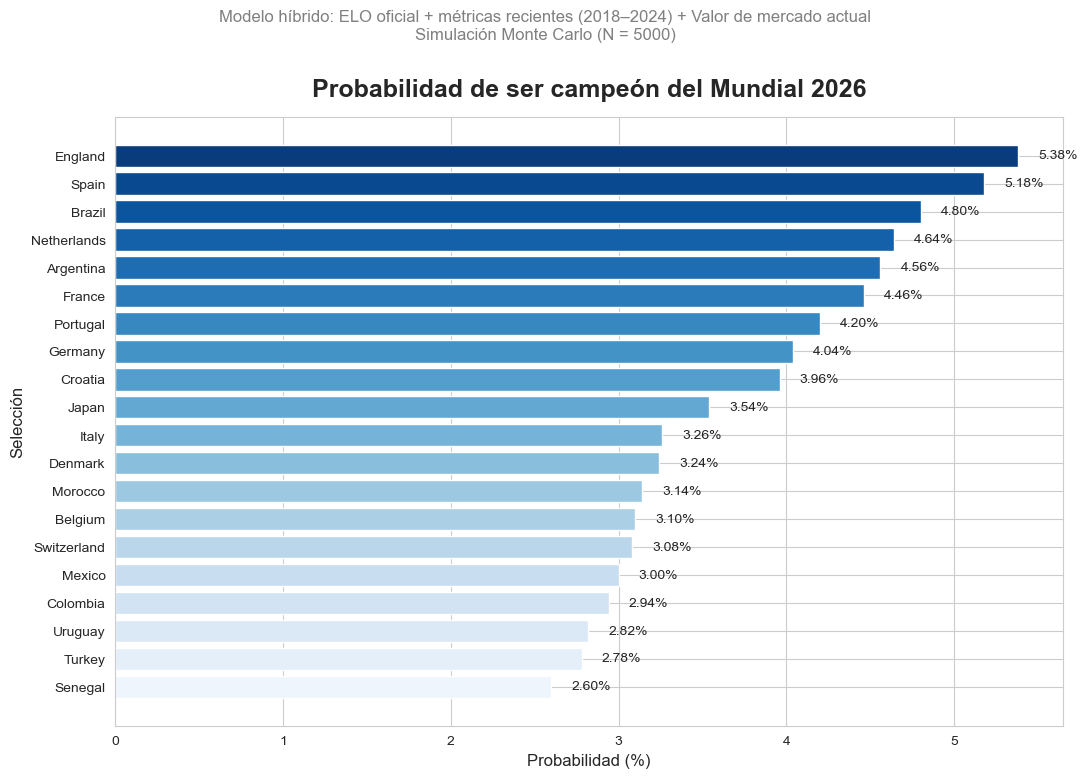

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = champions_prob.sort_values(ascending=True).tail(20)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(11, 8))

palette = sns.color_palette("Blues", n_colors=len(plot_df))

bars = ax.barh(plot_df.index, plot_df.values, color=palette)

# Agrego los valores al final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.12,
            bar.get_y() + bar.get_height()/2,
            f"{width:.2f}%",
            va='center',
            fontsize=10)

# Título principal (en el eje)
ax.set_title(
    "Probabilidad de ser campeón del Mundial 2026",
    fontsize=18,
    fontweight='bold',
    pad=15
)

# Subtítulo (en la figura, un poquito más arriba)
fig.text(
    0.5, 0.93,
    "Modelo híbrido: ELO oficial + métricas recientes (2018–2024) + Valor de mercado actual\n"
    "Simulación Monte Carlo (N = 5000)",
    ha='center',
    fontsize=12,
    color='gray'
)

ax.set_xlabel("Probabilidad (%)", fontsize=12)
ax.set_ylabel("Selección", fontsize=12)


fig.savefig(
    "../reports/figures/worldcup2026_champions_prob_top20.png",
    dpi=300,
    bbox_inches="tight"
)

# Dejo espacio arriba para que el subtítulo no se pise
plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.show()



In [60]:
output_path = "../data/processed/worldcup2026_montecarlo_top40.csv"

champions_prob.to_frame("probability_percent").to_csv(output_path)

print("Guardado en:", output_path)


Guardado en: ../data/processed/worldcup2026_montecarlo_top40.csv


In [38]:
team_features = team_features.set_index("team")


In [39]:
# Aseguro que 'team' exista como columna
if 'team' not in team_features.columns:
    team_features = team_features.reset_index().rename(columns={'index': 'team'})

# Pongo 'team' como índice
team_features = team_features.set_index("team")

cols_to_keep = [
    "elo", "modern_power", "market_value",
    "elo_norm", "modern_norm", "market_norm", "final_power"
]

team_features_export = team_features[cols_to_keep].copy()

output_path = "../data/processed/team_features_final.csv"
team_features_export.to_csv(output_path, index=True)  # guardo el índice como nombre del equipo

print("Guardado en:", output_path)
team_features_export.sort_values("final_power", ascending=False).head(20)


Guardado en: ../data/processed/team_features_final.csv


,elo,modern_power,market_value,elo_norm,modern_norm,market_norm,final_power
team,,,,,,,
Spain,2171.0,0.970647,900.0,1.000000,0.956571,0.741379,0.958938
England,2042.0,0.917277,1100.0,0.917148,0.927363,0.913793,0.920388
France,2062.0,0.777083,1050.0,0.929994,0.850637,0.870690,0.896288
Argentina,2113.0,0.693443,900.0,0.962749,0.804862,0.741379,0.885351
Brazil,1978.0,0.777976,1200.0,0.876044,0.851126,1.000000,0.879718
Portugal,1976.0,0.832487,950.0,0.874759,0.880959,0.784483,0.867901
Germany,1910.0,0.983060,850.0,0.832370,0.963365,0.698276,0.864809
Netherlands,1959.0,0.904762,820.0,0.863841,0.920514,0.672414,0.864534
Italy,1859.0,0.720942,750.0,0.799615,0.819912,0.612069,0.787964


In [31]:
team_features[team_features["market_value"].isna()].index.tolist()



[]